# Abandoned attempt with kBET's R package and scib Python wrapper

We first tried to run kBET through R and a Python wrapper.

Resources:

- https://github.com/theislab/scib-pipeline/blob/b2ddba53016fb0574c37fed0c45cc0c490bdac7c/envs/create_conda_environments.sh
- https://github.com/theislab/scib-pipeline/blob/b2ddba53016fb0574c37fed0c45cc0c490bdac7c/envs/scib-pipeline-R4.0.yml
- https://github.com/theislab/scib-pipeline/blob/b2ddba53016fb0574c37fed0c45cc0c490bdac7c/envs/env_vars_activate.sh
- https://github.com/theislab/scib-pipeline/blob/b2ddba53016fb0574c37fed0c45cc0c490bdac7c/scripts/metrics/metrics.py
- https://github.com/theislab/scib/blob/77ab015254754baa5ca3380bd592bcc9207241de/docs/source/installation.rst
- https://github.com/theislab/scib/blob/77ab015254754baa5ca3380bd592bcc9207241de/scib/metrics/kbet.py
- https://github.com/theislab/scib/blob/77ab015254754baa5ca3380bd592bcc9207241de/scib/metrics/metrics.py
- https://github.com/theislab/kBET/blob/f35171dfb04c7951b8a09ac778faf7424c4b6bc0/R/kBET-utils.R#L49
- https://github.com/theislab/kBET/blob/f35171dfb04c7951b8a09ac778faf7424c4b6bc0/R/kBET.R#L328


Environment setup within our main conda environment:

```bash
conda activate cuda-env-py39; # as usual
# install R and packages
mamba install -c conda-forge r-base=4.1 r-essentials r-devtools r-stringi rpy2 -y;
R --version # 4.1.1
Rscript --version # 4.1.1
R -e 'install.packages("tidyverse",repos = "http://cran.us.r-project.org")'
Rscript -e "remotes::install_github('theislab/kBET')"
pip install 'scib[rpy2] == 1.0.4'
```

The test we ran:

```python
# set env for rpy2. see https://github.com/theislab/scib-pipeline/blob/main/envs/env_vars_activate.sh
import os, subprocess

# in notebook, conda environment belonging to the kernel is not active in env vars, so have to set CONDA_PREFIX manually:
os.environ['CONDA_PREFIX'] = os.path.expandvars("$HOME/anaconda3/envs/cuda-env-py39")

os.environ["CFLAGS"] = subprocess.getoutput("gsl-config --cflags")
os.environ["LDFLAGS"] = subprocess.getoutput("gsl-config --libs")
os.environ["LD_LIBRARY_PATH"] = os.path.expandvars("${CONDA_PREFIX}/lib/R/lib/")
os.environ["QT_QPA_PLATFORM"] = "offscreen"
os.environ["R_HOME"] = os.path.expandvars("${CONDA_PREFIX}/lib/R")
os.environ["R_LIBS"] = ""

import rpy2 # v3.5.1
import rpy2.robjects as robjects # this will fail if os.environ not set right
from scib.metrics.kbet import kBET
print(kBET.__doc__)

# go with "full" type (https://github.com/theislab/scib-pipeline/blob/75ae100cf158191ee9097750e658b2f822cc837b/scripts/metrics/metrics.py#L27)
type_ = 'full'
embed = 'X_pca'
verbose = True
scaled=False # see kBET.__doc__: make it so that 0 means optimal batch mixing and 1 means low batch mixing, as described in paper

from malid import io
from malid.datamodels import GeneLocus, TargetObsColumnEnum
adata=io.load_fold_embeddings(
    fold_id=0,
    fold_label='test',
    gene_locus=GeneLocus.BCR,
    target_obs_column=TargetObsColumnEnum.disease
)
batch_key = "study_name"
label_key = "disease"
kbet_scores_df = kBET(
    adata=adata,
    batch_key=batch_key,
    label_key=label_key,
    type_=type_,
    embed=embed,
    scaled=scaled,
    verbose=verbose,
    return_df=True
)
kbet_scores_df
final_score = np.nanmean(kbet_scores_df["kBET"])
final_score = 1 - final_score if scaled else final_score
final_score
```

The problem: very slow compute. Our datasets are ~15x the max dataset size at which the scib benchmarking code disables kBET.

# Reimplementation

Instead we will reimplement based on this partial PR: https://github.com/scverse/scanpy/pull/364

kBET:

- from https://www.nature.com/articles/s41592-018-0254-1:

> In a dataset with replicates and no batch effects, the proportions of the batch labels in any neighborhood do not differ from the global distribution. In a replicated dataset with batch effects, data points from respective batches tend to cluster with their ‘peers’, and batch label proportions differ considerably between arbitrarily chosen neighborhoods

> Intuitively, a replicated experiment is well mixed if a subset of neighboring samples (e.g., single-cell transcriptomic data points) has the same distribution of batch labels as the full dataset.
>
> In contrast, a repetition of the experiment with some bias is expected to yield a skewed distribution of batch labels across the dataset.
>
> kBET uses a χ2-based test for random neighborhoods of fixed size to determine whether they are well mixed, followed by averaging of the binary test results to return an overall rejection rate. This result is easy to interpret: low rejection rates imply well-mixed replicates.

- from https://www.nature.com/articles/s41592-021-01336-8:

> The kBET algorithm (v.0.99.6, release 4c9dafa) determines whether the label composition of a k nearest neighborhood of a cell is similar to the expected (global) label composition. The test is repeated for a random subset of cells, and the results are summarized as a rejection rate over all tested neighborhoods.

> We applied kBET separately on the batch variable for each cell identity label. Using the kBET defaults, a k equal to the median of the number of cells per batch within each label was used for this computation. Additionally, we set the minimum and maximum thresholds of k to 10 and 100, respectively. As kNN graphs that have been subset by cell identity labels may no longer be connected, we computed kBET per connected component. If >25% of cells were assigned to connected components too small for kBET computation (smaller than k × 3), we assigned a kBET score of 1 to denote poor batch removal. Subsequently, kBET scores for each label were averaged and subtracted from 1 to give a final kBET score.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
import seaborn as sns
from scipy.stats import chisquare
from statsmodels.stats.multitest import multipletests
import anndata
from kdict import kdict
import gc
from IPython.display import display

In [2]:
from malid import io, helpers, logger, config
from malid.datamodels import GeneLocus, TargetObsColumnEnum

In [3]:
# Use GPU for kNN construction and queries
import choosegpu

choosegpu.configure_gpu(enable=True)

# Then import relevant methods
from malid.knn import _fit_knn_index, _get_neighbors

In [4]:
def kbet(
    adata: anndata.AnnData,
    batch_key: str,
    label_key: str,
    significance_threshold_alpha=0.05,
):
    """
    kBET reimplementation.
    Returns average-rejection-rate averages across labels; average rejection rate by label; all corrected p values for each label (not in same order as anndata obs)
    """
    rejection_rates_by_label = {}
    corrected_p_values_by_label = {}

    # Group by label_key
    # kBET is computed separately for each cell identity label, and only considers connections between cells of the same identity.
    for label, adata_label in helpers.anndata_groupby_obs(
        adata, label_key, observed=True
    ):
        batch_sizes = adata_label.obs[batch_key].value_counts()
        if batch_sizes.index.shape[0] == 1:
            logger.info(
                f"Skipping {label_key}={label} because it has only one {batch_key} batch"
            )
            continue

        # Choose neighborhood size, based on heuristics in kBET and scib
        neighborhood_size = batch_sizes.mean() // 4
        neighborhood_size = min([50, max([10, neighborhood_size])])
        # We also considered these alternative options:
        # "a k equal to the median of the number of cells per batch within each label was used for this computation.
        # Additionally, we set the minimum and maximum thresholds of k to 10 and 100, respectively."
        # We also saw clipping between 10 and int(batch_sizes.mean() * 3/4)
        # None of these make too much sense for our case where we have batch sizes in the tens of thousands
        # Everything will default to 50. (70 was the chosen default in some implementations we saw)

        # But we are keeping this sanity-check on the size from other implementations, though it doesn't seem that important:
        size_max = np.iinfo(np.int32).max
        if neighborhood_size * adata_label.shape[0] >= size_max:
            neighborhood_size = size_max // adata_label.shape[0]

        # Unlike kBET, we are just going to run once with a fixed neighborhood size
        logger.info(
            f"Running kBET on {label_key}={label} with neighborhood size {neighborhood_size} (based on batch sizes {batch_sizes.to_dict()})"
        )

        # Compute separate kNN graph for each identity subset
        # Note: the kBET and scib-benchmarking implementations compute a global kNN graph with cells of all identity labels, then subset it for each cell identity label. This means they have to deal with edge cases when the graph is no longer connected, so it looks like they end up running on each strongly connected component separately.
        # It seems like it’d be easier to just build a separate kNN graph for each cell identity label. However, this might connect cells that would otherwise be disconnected if they live in neighborhoods dominated by other cell identity labels. For the purpose of measuring batch integration within each cell identity label, I’m not sure this is a problem.
        # We will instead build separate kNN graphs for each identity-label subset of cells

        # Build kNN index
        knn_index = _fit_knn_index(X=adata_label.obsm["X_pca"])

        # Query kNN index
        neighbor_links_df = _get_neighbors(
            knn_index=knn_index,
            data_X_contiguous=adata_label.obsm["X_pca"],
            n_neighbors=neighborhood_size,
        )

        # Note when merging:
        # center_id and neighbor_id are integer ilocs (within adata_label), not obs_names / locs

        # prepare to merge by iloc later: create sequence_info that includes the integer index
        sequence_info = adata_label.obs[[batch_key, label_key]].reset_index(drop=True)
        # make columns catgegorical:
        sequence_info[batch_key] = sequence_info[batch_key].astype("category")
        sequence_info[label_key] = sequence_info[label_key].astype("category")

        # Merge in neighbor info
        # neighbor_id is an iloc within adata_label
        neighbor_links_df = pd.merge(
            neighbor_links_df,
            sequence_info.rename(columns=lambda s: f"neighbor_{s}"),
            how="left",
            left_on="neighbor_id",
            right_index=True,
            validate="m:1",
        )

        # merge in center info
        # center_id is a iloc within adata_label
        neighbor_links_df = pd.merge(
            neighbor_links_df,
            sequence_info.rename(columns=lambda s: f"center_{s}"),
            how="left",
            left_on="center_id",
            right_index=True,
            validate="m:1",
        )

        ## Compare label composition of k-nearest neighborhood of each sequence versus the expected (global) label composition

        ## Get expected neighborhood composition from global values: normalized value counts * chosen k neighbors
        expected_frequencies = (batch_sizes / batch_sizes.sum()) * neighborhood_size
        logger.info(
            f"kBET on {label_key}={label} with neighborhood size {neighborhood_size} has expected frequencies: {expected_frequencies.to_dict()}"
        )

        ## Get observed frequencies for each cell

        # First, confirm we computed the right number of neighbors
        total_num_neighbors = (
            neighbor_links_df.groupby(["center_id"], observed=True)
            .size()
            .rename("total_num_neighbors")
        )
        assert all(total_num_neighbors == neighborhood_size)
        # Also sanity check that all identity labels are the same
        assert (
            neighbor_links_df[f"center_{label_key}"]
            == neighbor_links_df[f"neighbor_{label_key}"]
        ).all()
        assert (neighbor_links_df[f"center_{label_key}"] == label).all()

        # Get neighborhood batch frequencies for each cell
        # https://stackoverflow.com/a/39132900/130164
        observed_neighbor_batch_frequencies = (
            neighbor_links_df.groupby(
                ["center_id", f"neighbor_{batch_key}"], observed=True
            )
            .size()
            .unstack(fill_value=0)
        )

        # rearrange order to match
        assert set(observed_neighbor_batch_frequencies.columns) == set(
            expected_frequencies.index
        )
        expected_frequencies = expected_frequencies.loc[
            observed_neighbor_batch_frequencies.columns
        ]

        # Compute test statistic for each cell
        # "kBET uses a χ2-based test for random neighborhoods of fixed size to determine whether they are well mixed,
        # followed by averaging of the binary test results to return an overall rejection rate.
        # This result is easy to interpret: low rejection rates imply well-mixed replicates."
        chisquared_test_statistic, p_values_uncorrected = chisquare(
            f_obs=observed_neighbor_batch_frequencies,
            f_exp=expected_frequencies,
            axis=1,
        )

        # Correct for multiple hypothesis testing
        is_wellmixed_null_hypothesis_rejected, corrected_p_values, _, _ = multipletests(
            pvals=p_values_uncorrected,
            alpha=significance_threshold_alpha,
            method="fdr_tsbh",
        )
        # is_wellmixed_null_hypothesis_rejected is a numpy array of booleans
        rejection_rate = is_wellmixed_null_hypothesis_rejected.mean()

        # Store result for each label
        rejection_rates_by_label[label] = rejection_rate
        # note that corrected_p_values are not in order of obsnames and should thus not be glued onto adata.obs or adata_label.obs
        corrected_p_values_by_label[label] = corrected_p_values

    # Aggregate the results across labels
    # "Subsequently, kBET scores for each label were averaged and subtracted from 1 to give a final kBET score."
    # ^ This subtraction seems to only be in scib benchmarking and the scanpy partial PR.
    # Really we should keep it as rejection rate, so 0 means null hypothesis was not rejected much, suggesting the well-mixed hypothesis holds.

    # Returns average-rejection-rate averages across labels; average rejection rate by label; all corrected p values for each label (not in same order as anndata obs)
    return (
        np.mean(list(rejection_rates_by_label.values())),
        rejection_rates_by_label,
        corrected_p_values_by_label,
    )

In [5]:
# kBET will be computed amongst all sequences with same [label_key]
label_key = "disease"

# kBET will compute whether [batch_key] batches are well-mixed within each [label_key]
batch_key = "study_name"

# run on:
fold_label = "test"

# plot labels
xlabel = "kBET χ² test corrected p-value"
ylabel = "Disease"

2023-01-04 20:01:57,295 - kbet_batch_evaluation.ipynb - INFO - Running on GeneLocus.BCR, fold 0-test


2023-01-04 20:01:57,308 - malid.external.scratch_cache - INFO - Reading network file from local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/BCR/fold.0.test.h5ad -> /srv/scratch/maximz/cache/d23bdbcb1cb8d1c3007da595727fbbab8cc86779ab8967868314f2da.0.test.h5ad


Only considering the two last: ['.test', '.h5ad'].


Only considering the two last: ['.test', '.h5ad'].


2023-01-04 20:04:11,196 - malid.helpers - WARNING - Not marking any sequences as confident_sequence because those annotations weren't found: [Errno 2] No such file or directory: '/users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/BCR/neighborhoods/knn_neighborhood.0.test.IGHG.embedded_onto.train_smaller.combined_data.filtered.tsv.gz'


disease             study_name                 
HIV                 HIV                             784893
Healthy/Background  HIV                             249042
                    Healthy-StanfordBloodCenter    1913568
                    Lupus                           140020
                    New Lupus Paxgene                47523
                    New Lupus RNA                    41810
                    healthy_children                345718
Lupus               Lupus                           169557
                    Lupus Pediatric                 838515
                    New Lupus Paxgene               104170
                    New Lupus RNA                   121163
Covid19             Covid19-Seattle                  41375
                    Covid19-Stanford                 78555
                    Covid19-buffycoat               138369
dtype: int64


2023-01-04 20:05:02,958 - kbet_batch_evaluation.ipynb - INFO - Skipping disease=HIV because it has only one study_name batch


2023-01-04 20:05:44,462 - kbet_batch_evaluation.ipynb - INFO - Running kBET on disease=Healthy/Background with neighborhood size 50 (based on batch sizes {'Healthy-StanfordBloodCenter': 1913568, 'healthy_children': 345718, 'HIV': 249042, 'Lupus': 140020, 'New Lupus Paxgene': 47523, 'New Lupus RNA': 41810})


2023-01-04 20:13:38,046 - kbet_batch_evaluation.ipynb - INFO - kBET on disease=Healthy/Background with neighborhood size 50 has expected frequencies: {'Healthy-StanfordBloodCenter': 34.948702935075346, 'healthy_children': 6.314066540257977, 'HIV': 4.548411593607875, 'Lupus': 2.5572738386977885, 'New Lupus Paxgene': 0.8679426127441436, 'New Lupus RNA': 0.7636024796168728}


2023-01-04 20:14:16,351 - kbet_batch_evaluation.ipynb - INFO - Running kBET on disease=Lupus with neighborhood size 50 (based on batch sizes {'Lupus Pediatric': 838515, 'Lupus': 169557, 'New Lupus RNA': 121163, 'New Lupus Paxgene': 104170})


2023-01-04 20:16:00,654 - kbet_batch_evaluation.ipynb - INFO - kBET on disease=Lupus with neighborhood size 50 has expected frequencies: {'Lupus Pediatric': 33.99187614773736, 'Lupus': 6.873533024432364, 'New Lupus RNA': 4.911728102285949, 'New Lupus Paxgene': 4.222862725544326}


2023-01-04 20:16:14,193 - kbet_batch_evaluation.ipynb - INFO - Running kBET on disease=Covid19 with neighborhood size 50 (based on batch sizes {'Covid19-buffycoat': 138369, 'Covid19-Stanford': 78555, 'Covid19-Seattle': 41375})


2023-01-04 20:16:24,335 - kbet_batch_evaluation.ipynb - INFO - kBET on disease=Covid19 with neighborhood size 50 has expected frequencies: {'Covid19-buffycoat': 26.784656541450026, 'Covid19-Stanford': 15.206214503346896, 'Covid19-Seattle': 8.00912895520308}


kBET result for GeneLocus.BCR, fold 0-test: 0.20830 average of average rejection rate by label
Average rejection rates for each label


,disease,average_rejection_rate,fold_id,fold_label,gene_locus
0,Healthy/Background,0.132656,0,test,BCR
1,Lupus,0.115432,0,test,BCR
2,Covid19,0.376819,0,test,BCR


2023-01-04 20:16:32,874 - kbet_batch_evaluation.ipynb - INFO - Running on GeneLocus.BCR, fold 1-test


2023-01-04 20:16:32,878 - malid.external.scratch_cache - INFO - Reading network file from local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/BCR/fold.1.test.h5ad -> /srv/scratch/maximz/cache/ed1f2608e168c24c508b6bfbbe3a18ba1a4680e5c010e34cd184cae6.1.test.h5ad


************************************************************
Only considering the two last: ['.test', '.h5ad'].


Only considering the two last: ['.test', '.h5ad'].


2023-01-04 20:18:38,749 - malid.helpers - WARNING - Not marking any sequences as confident_sequence because those annotations weren't found: [Errno 2] No such file or directory: '/users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/BCR/neighborhoods/knn_neighborhood.1.test.IGHG.embedded_onto.train_smaller.combined_data.filtered.tsv.gz'


disease             study_name                 
Healthy/Background  HIV                             377110
                    Healthy-StanfordBloodCenter    1317978
                    Lupus                           115147
                    healthy_children                427846
HIV                 HIV                             934148
Lupus               Lupus                           221957
                    Lupus Pediatric                 826728
                    New Lupus Paxgene                70706
                    New Lupus RNA                    73938
Covid19             Covid19-Seattle                 126983
                    Covid19-Stanford                199740
                    Covid19-buffycoat                13718
dtype: int64


2023-01-04 20:21:08,672 - kbet_batch_evaluation.ipynb - INFO - Running kBET on disease=Healthy/Background with neighborhood size 50 (based on batch sizes {'Healthy-StanfordBloodCenter': 1317978, 'healthy_children': 427846, 'HIV': 377110, 'Lupus': 115147})


2023-01-04 20:38:14,429 - kbet_batch_evaluation.ipynb - INFO - kBET on disease=Healthy/Background with neighborhood size 50 has expected frequencies: {'Healthy-StanfordBloodCenter': 29.44437667805589, 'healthy_children': 9.558322509328304, 'HIV': 8.42485146873594, 'Lupus': 2.572449343879869}


2023-01-04 20:38:41,594 - kbet_batch_evaluation.ipynb - INFO - Skipping disease=HIV because it has only one study_name batch


2023-01-04 20:41:48,354 - kbet_batch_evaluation.ipynb - INFO - Running kBET on disease=Lupus with neighborhood size 50 (based on batch sizes {'Lupus Pediatric': 826728, 'Lupus': 221957, 'New Lupus RNA': 73938, 'New Lupus Paxgene': 70706})


2023-01-04 20:47:58,355 - kbet_batch_evaluation.ipynb - INFO - kBET on disease=Lupus with neighborhood size 50 has expected frequencies: {'Lupus Pediatric': 34.63956712691974, 'Lupus': 9.299908072291881, 'New Lupus RNA': 3.097972143474264, 'New Lupus Paxgene': 2.9625526573141188}


2023-01-04 20:48:13,039 - kbet_batch_evaluation.ipynb - INFO - Running kBET on disease=Covid19 with neighborhood size 50 (based on batch sizes {'Covid19-Stanford': 199740, 'Covid19-Seattle': 126983, 'Covid19-buffycoat': 13718})


2023-01-04 20:48:31,394 - kbet_batch_evaluation.ipynb - INFO - kBET on disease=Covid19 with neighborhood size 50 has expected frequencies: {'Covid19-Stanford': 29.335479569147076, 'Covid19-Seattle': 18.64978072558828, 'Covid19-buffycoat': 2.014739705264642}


kBET result for GeneLocus.BCR, fold 1-test: 0.24768 average of average rejection rate by label
Average rejection rates for each label


,disease,average_rejection_rate,fold_id,fold_label,gene_locus
0,Healthy/Background,0.186631,1,test,BCR
1,Lupus,0.259052,1,test,BCR
2,Covid19,0.297355,1,test,BCR


2023-01-04 20:48:41,343 - kbet_batch_evaluation.ipynb - INFO - Running on GeneLocus.BCR, fold 2-test


2023-01-04 20:48:41,358 - malid.external.scratch_cache - INFO - Reading network file from local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/BCR/fold.2.test.h5ad -> /srv/scratch/maximz/cache/83dcd409138574af7b7b712ce14967e926c14170bff7801b141edb49.2.test.h5ad


************************************************************
Only considering the two last: ['.test', '.h5ad'].


Only considering the two last: ['.test', '.h5ad'].


2023-01-04 21:05:47,359 - malid.helpers - WARNING - Not marking any sequences as confident_sequence because those annotations weren't found: [Errno 2] No such file or directory: '/users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/BCR/neighborhoods/knn_neighborhood.2.test.IGHG.embedded_onto.train_smaller.combined_data.filtered.tsv.gz'


disease             study_name                 
HIV                 HIV                            1043723
Healthy/Background  HIV                             206222
                    Healthy-StanfordBloodCenter    1509330
                    Lupus                           110264
                    New Lupus Paxgene                69828
                    New Lupus RNA                    83766
                    healthy_children                361373
Lupus               Lupus                           128841
                    Lupus Pediatric                 590951
                    New Lupus Paxgene               111879
                    New Lupus RNA                   101727
Covid19             Covid19-Seattle                 107718
                    Covid19-Stanford                125267
                    Covid19-buffycoat               104568
dtype: int64


2023-01-04 21:14:38,240 - kbet_batch_evaluation.ipynb - INFO - Skipping disease=HIV because it has only one study_name batch


2023-01-04 21:24:07,295 - kbet_batch_evaluation.ipynb - INFO - Running kBET on disease=Healthy/Background with neighborhood size 50 (based on batch sizes {'Healthy-StanfordBloodCenter': 1509330, 'healthy_children': 361373, 'HIV': 206222, 'Lupus': 110264, 'New Lupus RNA': 83766, 'New Lupus Paxgene': 69828})


2023-01-04 22:00:26,382 - kbet_batch_evaluation.ipynb - INFO - kBET on disease=Healthy/Background with neighborhood size 50 has expected frequencies: {'Healthy-StanfordBloodCenter': 32.23985307480446, 'healthy_children': 7.7190623821174364, 'HIV': 4.404979017704759, 'Lupus': 2.355280263057276, 'New Lupus RNA': 1.7892730765730953, 'New Lupus Paxgene': 1.4915521857429757}


2023-01-04 22:05:00,728 - kbet_batch_evaluation.ipynb - INFO - Running kBET on disease=Lupus with neighborhood size 50 (based on batch sizes {'Lupus Pediatric': 590951, 'Lupus': 128841, 'New Lupus Paxgene': 111879, 'New Lupus RNA': 101727})


2023-01-04 22:19:54,768 - kbet_batch_evaluation.ipynb - INFO - kBET on disease=Lupus with neighborhood size 50 has expected frequencies: {'Lupus Pediatric': 31.65589598434966, 'Lupus': 6.901718238093503, 'New Lupus Paxgene': 5.993102620746991, 'New Lupus RNA': 5.44928315680985}


2023-01-04 22:20:15,130 - kbet_batch_evaluation.ipynb - INFO - Running kBET on disease=Covid19 with neighborhood size 50 (based on batch sizes {'Covid19-Stanford': 125267, 'Covid19-Seattle': 107718, 'Covid19-buffycoat': 104568})


2023-01-04 22:24:49,457 - kbet_batch_evaluation.ipynb - INFO - kBET on disease=Covid19 with neighborhood size 50 has expected frequencies: {'Covid19-Stanford': 18.555160226690326, 'Covid19-Seattle': 15.955716583766105, 'Covid19-buffycoat': 15.48912318954357}


kBET result for GeneLocus.BCR, fold 2-test: 0.20326 average of average rejection rate by label
Average rejection rates for each label


,disease,average_rejection_rate,fold_id,fold_label,gene_locus
0,Healthy/Background,0.125485,2,test,BCR
1,Lupus,0.136382,2,test,BCR
2,Covid19,0.347907,2,test,BCR


2023-01-04 22:24:58,411 - kbet_batch_evaluation.ipynb - INFO - Running on GeneLocus.TCR, fold 0-test


2023-01-04 22:24:58,422 - malid.external.scratch_cache - INFO - Reading network file from local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/TCR/fold.0.test.h5ad -> /srv/scratch/maximz/cache/a6c3ab8bb9960154ff8dbb5d04eaf7a1c395f034f82f9649aefc9d35.0.test.h5ad


************************************************************
Only considering the two last: ['.test', '.h5ad'].


Only considering the two last: ['.test', '.h5ad'].


2023-01-04 22:43:52,489 - malid.helpers - WARNING - Not marking any sequences as confident_sequence because those annotations weren't found: [Errno 2] No such file or directory: '/users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/TCR/neighborhoods/knn_neighborhood.0.test.TCRB.embedded_onto.train_smaller.combined_data.filtered.tsv.gz'


disease             study_name                 
HIV                 HIV                            1056382
Healthy/Background  HIV                             407479
                    Healthy-StanfordBloodCenter    2209724
                    New Lupus Paxgene               144384
                    New Lupus RNA                    44397
                    healthy_children               1094828
Covid19             Covid19-Stanford                156902
                    Covid19-buffycoat               132806
Lupus               Lupus Pediatric                 919217
                    New Lupus Paxgene               375567
                    New Lupus RNA                   117954
dtype: int64


2023-01-04 22:47:59,495 - kbet_batch_evaluation.ipynb - INFO - Skipping disease=HIV because it has only one study_name batch


2023-01-04 23:01:54,154 - kbet_batch_evaluation.ipynb - INFO - Running kBET on disease=Healthy/Background with neighborhood size 50 (based on batch sizes {'Healthy-StanfordBloodCenter': 2209724, 'healthy_children': 1094828, 'HIV': 407479, 'New Lupus Paxgene': 144384, 'New Lupus RNA': 44397})


2023-01-04 23:49:04,202 - kbet_batch_evaluation.ipynb - INFO - kBET on disease=Healthy/Background with neighborhood size 50 has expected frequencies: {'Healthy-StanfordBloodCenter': 28.32389769104484, 'healthy_children': 14.033334598027283, 'HIV': 5.223002287728811, 'New Lupus Paxgene': 1.8506915995951612, 'New Lupus RNA': 0.569073823603906}


2023-01-04 23:50:02,295 - kbet_batch_evaluation.ipynb - INFO - Running kBET on disease=Covid19 with neighborhood size 50 (based on batch sizes {'Covid19-Stanford': 156902, 'Covid19-buffycoat': 132806})


2023-01-04 23:50:15,314 - kbet_batch_evaluation.ipynb - INFO - kBET on disease=Covid19 with neighborhood size 50 has expected frequencies: {'Covid19-Stanford': 27.079335054606705, 'Covid19-buffycoat': 22.920664945393295}


2023-01-04 23:50:22,762 - kbet_batch_evaluation.ipynb - INFO - Running kBET on disease=Lupus with neighborhood size 50 (based on batch sizes {'Lupus Pediatric': 919217, 'New Lupus Paxgene': 375567, 'New Lupus RNA': 117954})


2023-01-04 23:59:57,395 - kbet_batch_evaluation.ipynb - INFO - kBET on disease=Lupus with neighborhood size 50 has expected frequencies: {'Lupus Pediatric': 32.53317317152933, 'New Lupus Paxgene': 13.292167408252627, 'New Lupus RNA': 4.1746594202180445}


kBET result for GeneLocus.TCR, fold 0-test: 0.14451 average of average rejection rate by label
Average rejection rates for each label


,disease,average_rejection_rate,fold_id,fold_label,gene_locus
0,Healthy/Background,0.117520,0,test,TCR
1,Covid19,0.110456,0,test,TCR
2,Lupus,0.205555,0,test,TCR


2023-01-05 00:00:52,989 - kbet_batch_evaluation.ipynb - INFO - Running on GeneLocus.TCR, fold 1-test


2023-01-05 00:00:53,000 - malid.external.scratch_cache - INFO - Reading network file from local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/TCR/fold.1.test.h5ad -> /srv/scratch/maximz/cache/d3eb18b805f6482478ad1ee75a5249a449864d796469d3e144db1326.1.test.h5ad


************************************************************
Only considering the two last: ['.test', '.h5ad'].


Only considering the two last: ['.test', '.h5ad'].


2023-01-05 00:21:42,450 - malid.helpers - WARNING - Not marking any sequences as confident_sequence because those annotations weren't found: [Errno 2] No such file or directory: '/users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/TCR/neighborhoods/knn_neighborhood.1.test.TCRB.embedded_onto.train_smaller.combined_data.filtered.tsv.gz'


disease             study_name                 
Healthy/Background  HIV                             683742
                    Healthy-StanfordBloodCenter    1662722
                    healthy_children               1531012
HIV                 HIV                            1017051
Covid19             Covid19-Stanford                279990
                    Covid19-buffycoat                15408
Lupus               Lupus Pediatric                 767336
                    New Lupus Paxgene               123300
                    New Lupus RNA                   197251
dtype: int64


2023-01-05 00:39:28,996 - kbet_batch_evaluation.ipynb - INFO - Running kBET on disease=Healthy/Background with neighborhood size 50 (based on batch sizes {'Healthy-StanfordBloodCenter': 1662722, 'healthy_children': 1531012, 'HIV': 683742})


2023-01-05 01:35:56,779 - kbet_batch_evaluation.ipynb - INFO - kBET on disease=Healthy/Background with neighborhood size 50 has expected frequencies: {'Healthy-StanfordBloodCenter': 21.44077745419959, 'healthy_children': 19.742378805181517, 'HIV': 8.816843740618898}


2023-01-05 01:37:50,300 - kbet_batch_evaluation.ipynb - INFO - Skipping disease=HIV because it has only one study_name batch


2023-01-05 01:37:51,358 - kbet_batch_evaluation.ipynb - INFO - Running kBET on disease=Covid19 with neighborhood size 50 (based on batch sizes {'Covid19-Stanford': 279990, 'Covid19-buffycoat': 15408})


2023-01-05 01:38:03,620 - kbet_batch_evaluation.ipynb - INFO - kBET on disease=Covid19 with neighborhood size 50 has expected frequencies: {'Covid19-Stanford': 47.391993175309246, 'Covid19-buffycoat': 2.608006824690756}


2023-01-05 01:38:10,661 - kbet_batch_evaluation.ipynb - INFO - Running kBET on disease=Lupus with neighborhood size 50 (based on batch sizes {'Lupus Pediatric': 767336, 'New Lupus RNA': 197251, 'New Lupus Paxgene': 123300})


2023-01-05 01:42:12,776 - kbet_batch_evaluation.ipynb - INFO - kBET on disease=Lupus with neighborhood size 50 has expected frequencies: {'Lupus Pediatric': 35.2672658097762, 'New Lupus RNA': 9.065785325130275, 'New Lupus Paxgene': 5.666948865093525}


kBET result for GeneLocus.TCR, fold 1-test: 0.11892 average of average rejection rate by label
Average rejection rates for each label


,disease,average_rejection_rate,fold_id,fold_label,gene_locus
0,Healthy/Background,0.190312,1,test,TCR
1,Covid19,0.023064,1,test,TCR
2,Lupus,0.143375,1,test,TCR


2023-01-05 01:42:31,695 - kbet_batch_evaluation.ipynb - INFO - Running on GeneLocus.TCR, fold 2-test


2023-01-05 01:42:31,705 - malid.external.scratch_cache - INFO - Reading network file from local machine cache: /users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/TCR/fold.2.test.h5ad -> /srv/scratch/maximz/cache/d74a0f1a51ad1e35ec4654f627621ecdc4abf48e3481e399db8af384.2.test.h5ad


************************************************************
Only considering the two last: ['.test', '.h5ad'].


Only considering the two last: ['.test', '.h5ad'].


2023-01-05 01:54:02,580 - malid.helpers - WARNING - Not marking any sequences as confident_sequence because those annotations weren't found: [Errno 2] No such file or directory: '/users/maximz/code/boyd-immune-repertoire-classification/data/data_v_20221224/embedded/unirep_fine_tuned/anndatas_scaled/TCR/neighborhoods/knn_neighborhood.2.test.TCRB.embedded_onto.train_smaller.combined_data.filtered.tsv.gz'


disease             study_name                 
HIV                 HIV                            1091248
Healthy/Background  HIV                             381294
                    Healthy-StanfordBloodCenter    1931036
                    New Lupus Paxgene               233446
                    New Lupus RNA                    63238
                    healthy_children               1208885
Covid19             Covid19-Stanford                217108
                    Covid19-buffycoat                45354
Lupus               Lupus Pediatric                 676172
                    New Lupus Paxgene               241256
                    New Lupus RNA                   205338
dtype: int64


2023-01-05 02:03:26,674 - kbet_batch_evaluation.ipynb - INFO - Skipping disease=HIV because it has only one study_name batch


2023-01-05 02:15:35,959 - kbet_batch_evaluation.ipynb - INFO - Running kBET on disease=Healthy/Background with neighborhood size 50 (based on batch sizes {'Healthy-StanfordBloodCenter': 1931036, 'healthy_children': 1208885, 'HIV': 381294, 'New Lupus Paxgene': 233446, 'New Lupus RNA': 63238})


2023-01-05 03:10:40,184 - kbet_batch_evaluation.ipynb - INFO - kBET on disease=Healthy/Background with neighborhood size 50 has expected frequencies: {'Healthy-StanfordBloodCenter': 25.289249401306847, 'healthy_children': 15.831809589515073, 'HIV': 4.993505590378373, 'New Lupus Paxgene': 3.0572574078046593, 'New Lupus RNA': 0.8281780109950525}


2023-01-05 03:17:22,155 - kbet_batch_evaluation.ipynb - INFO - Running kBET on disease=Covid19 with neighborhood size 50 (based on batch sizes {'Covid19-Stanford': 217108, 'Covid19-buffycoat': 45354})


2023-01-05 03:18:10,148 - kbet_batch_evaluation.ipynb - INFO - kBET on disease=Covid19 with neighborhood size 50 has expected frequencies: {'Covid19-Stanford': 41.35989209866571, 'Covid19-buffycoat': 8.64010790133429}


2023-01-05 03:18:57,151 - kbet_batch_evaluation.ipynb - INFO - Running kBET on disease=Lupus with neighborhood size 50 (based on batch sizes {'Lupus Pediatric': 676172, 'New Lupus Paxgene': 241256, 'New Lupus RNA': 205338})


2023-01-05 03:38:39,941 - kbet_batch_evaluation.ipynb - INFO - kBET on disease=Lupus with neighborhood size 50 has expected frequencies: {'Lupus Pediatric': 30.11188439977698, 'New Lupus Paxgene': 10.743823735310832, 'New Lupus RNA': 9.14429186491219}


kBET result for GeneLocus.TCR, fold 2-test: 0.10087 average of average rejection rate by label
Average rejection rates for each label


,disease,average_rejection_rate,fold_id,fold_label,gene_locus
0,Healthy/Background,0.122114,2,test,TCR
1,Covid19,0.017919,2,test,TCR
2,Lupus,0.162584,2,test,TCR


************************************************************


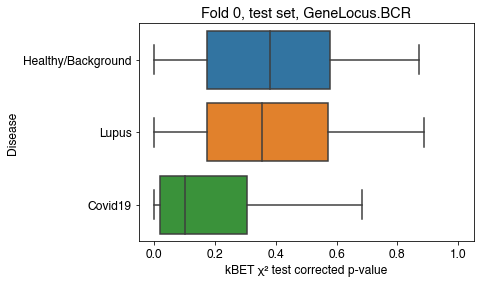

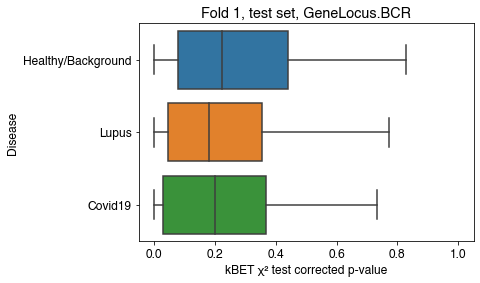

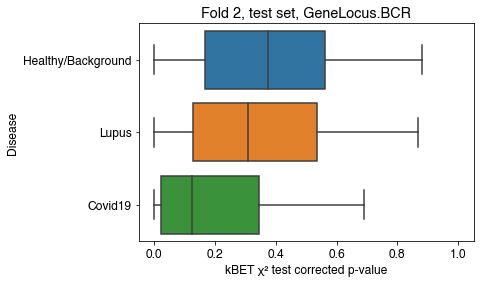

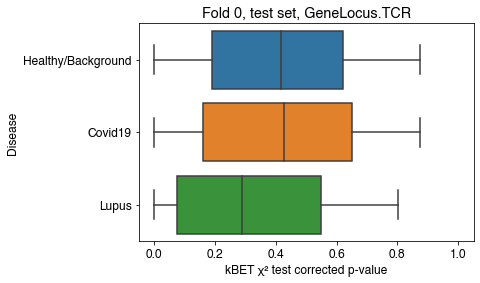

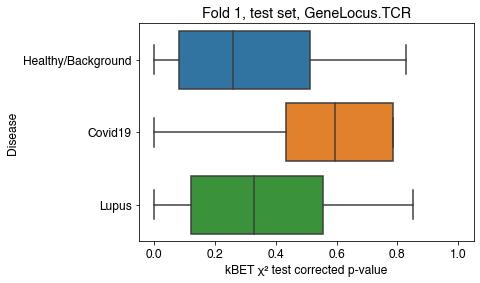

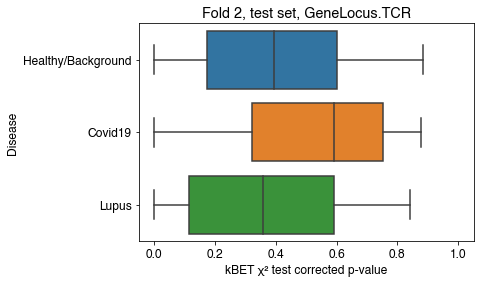

In [6]:
kbet_results = kdict()
for gene_locus in config.gene_loci_used:
    for fold_id in config.cross_validation_fold_ids:
        logger.info(f"Running on {gene_locus}, fold {fold_id}-{fold_label}")
        adata = io.load_fold_embeddings(
            fold_id=fold_id,
            fold_label=fold_label,
            gene_locus=gene_locus,
            target_obs_column=TargetObsColumnEnum.disease,
        )
        # PCA was precomputed with 50 dims
        assert adata.obsm["X_pca"].shape[1] == 50
        print(adata.obs.groupby([label_key, batch_key], observed=True).size())

        # Plot kBET on each disease label
        (
            average_rejection_rate_overall,
            average_rejection_rates_by_label,
            corrected_p_values_by_label,
        ) = kbet(
            adata=adata,
            batch_key=batch_key,
            label_key=label_key,
            significance_threshold_alpha=0.05,
        )

        # Save results
        # reformat dict as dataframe
        average_rejection_rates_by_label = (
            pd.Series(average_rejection_rates_by_label)
            .rename("average_rejection_rate")
            .rename_axis(index=label_key)
            .reset_index()
            .assign(fold_id=fold_id, fold_label=fold_label, gene_locus=gene_locus.name)
        )
        kbet_results[gene_locus, fold_id, fold_label] = (
            average_rejection_rate_overall,
            average_rejection_rates_by_label,
        )

        # Print results
        print(
            f"kBET result for {gene_locus}, fold {fold_id}-{fold_label}: {average_rejection_rate_overall:0.5f} average of average rejection rate by label"
        )
        print("Average rejection rates for each label")
        display(average_rejection_rates_by_label)

        # Plot per-sequence corrected p values
        fig, ax = plt.subplots()
        sns.boxplot(
            data=pd.concat(
                [
                    pd.DataFrame(v, columns=[xlabel]).assign(**{ylabel: k})
                    for k, v in corrected_p_values_by_label.items()
                ]
            ),
            x=xlabel,
            y=ylabel,
            ax=ax,
        )
        plt.title(f"Fold {fold_id}, {fold_label} set, {gene_locus}")
        plt.xlim(-0.05, 1.05)

        # Clear cache before moving onto next fold
        io.clear_cached_fold_embeddings()
        gc.collect()

        print("*" * 60)

# Review all results

In [7]:
# Show all results as a table
all_results_overall = pd.DataFrame.from_records(
    dict(
        gene_locus=gene_locus.name,
        fold_id=fold_id,
        fold_label=fold_label,
        average_rejection_rate_overall=average_rejection_rate_overall,
    )
    for (gene_locus, fold_id, fold_label), (
        average_rejection_rate_overall,
        _,
    ) in kbet_results.items()
)
all_results_overall

,gene_locus,fold_id,fold_label,average_rejection_rate_overall
0,BCR,0,test,0.208303
1,BCR,1,test,0.247679
2,BCR,2,test,0.203258
3,TCR,0,test,0.144510
4,TCR,1,test,0.118917
5,TCR,2,test,0.100872


In [8]:
all_results_overall.to_csv(
    config.paths.output_dir
    / "kbet_batch_evaluation.overall_results_by_genelocus_and_fold.tsv",
    sep="\t",
    index=None,
)

In [9]:
all_results_overall = pd.read_csv(
    config.paths.output_dir
    / "kbet_batch_evaluation.overall_results_by_genelocus_and_fold.tsv",
    sep="\t",
)
all_results_overall

,gene_locus,fold_id,fold_label,average_rejection_rate_overall
0,BCR,0,test,0.208303
1,BCR,1,test,0.247679
2,BCR,2,test,0.203258
3,TCR,0,test,0.144510
4,TCR,1,test,0.118917
5,TCR,2,test,0.100872


In [10]:
# Remember: 0 means optimal batch mixing and 1 means low batch mixing
# For each locus+fold, we took average across all cells within each label, then average across all labels
# And now we can report average +/- std across folds by locus+disease, or by locus, or overall

In [11]:
# agg by locus
all_results_overall.groupby("gene_locus")["average_rejection_rate_overall"].agg(
    ["mean", "std"]
)

,mean,std
gene_locus,,
BCR,0.219747,0.024322
TCR,0.121433,0.021928


In [12]:
# agg over all
all_results_overall["average_rejection_rate_overall"].agg(["mean", "std"])

mean    0.170590
std     0.057694
Name: average_rejection_rate_overall, dtype: float64

In [13]:
# All results at per-label specificity (i.e. before we take average over all labels)
all_results_per_label = pd.concat(
    (
        average_rejection_rates_by_label
        for (_, average_rejection_rates_by_label) in kbet_results.values()
    ),
    axis=0,
).reset_index(drop=True)
all_results_per_label

,disease,average_rejection_rate,fold_id,fold_label,gene_locus
0,Healthy/Background,0.132656,0,test,BCR
1,Lupus,0.115432,0,test,BCR
2,Covid19,0.376819,0,test,BCR
3,Healthy/Background,0.186631,1,test,BCR
4,Lupus,0.259052,1,test,BCR
5,Covid19,0.297355,1,test,BCR
6,Healthy/Background,0.125485,2,test,BCR
7,Lupus,0.136382,2,test,BCR
8,Covid19,0.347907,2,test,BCR
9,Healthy/Background,0.117520,0,test,TCR


In [14]:
all_results_per_label.to_csv(
    config.paths.output_dir
    / "kbet_batch_evaluation.per_label_results_by_genelocus_and_fold.tsv",
    sep="\t",
    index=None,
)

In [15]:
all_results_per_label = pd.read_csv(
    config.paths.output_dir
    / "kbet_batch_evaluation.per_label_results_by_genelocus_and_fold.tsv",
    sep="\t",
)
all_results_per_label

,disease,average_rejection_rate,fold_id,fold_label,gene_locus
0,Healthy/Background,0.132656,0,test,BCR
1,Lupus,0.115432,0,test,BCR
2,Covid19,0.376819,0,test,BCR
3,Healthy/Background,0.186631,1,test,BCR
4,Lupus,0.259052,1,test,BCR
5,Covid19,0.297355,1,test,BCR
6,Healthy/Background,0.125485,2,test,BCR
7,Lupus,0.136382,2,test,BCR
8,Covid19,0.347907,2,test,BCR
9,Healthy/Background,0.117520,0,test,TCR


In [16]:
all_results_per_label.groupby(["gene_locus", "disease"])["average_rejection_rate"].agg(
    ["mean", "std"]
)

mean       std
gene_locus disease                               
BCR        Covid19             0.340694  0.040220
           Healthy/Background  0.148257  0.033425
           Lupus               0.170289  0.077581
TCR        Covid19             0.050480  0.052005
           Healthy/Background  0.143315  0.040765
           Lupus               0.170505  0.031837

In [17]:
all_results_per_label.groupby(["gene_locus"])["average_rejection_rate"].agg(
    ["mean", "std"]
)

,mean,std
gene_locus,,
BCR,0.219747,0.102508
TCR,0.121433,0.065692


In [18]:
all_results_per_label["average_rejection_rate"].agg(["mean", "std"])

mean    0.170590
std     0.097643
Name: average_rejection_rate, dtype: float64